In [1]:
import predefined as pre

from matplotlib import pyplot
import pandas as pd 
import pmdarima as pm

rawdata = pre.LoadRawData(csv='..\\data\\asof_Q1_22.csv')
rawdata.create_pkl(pkl='..\\pkl\\df_raw.pkl')
df_raw = rawdata.load_pkl(pkl='..\\pkl\\df_raw.pkl')

"..\pkl\df_raw.pkl" has been created


# EDA

In [ ]:
df_raw.loc[:,df_raw.columns[:-3]].plot(subplots=True,figsize =(18,24))
pyplot.show()

## Resampling: Monthly

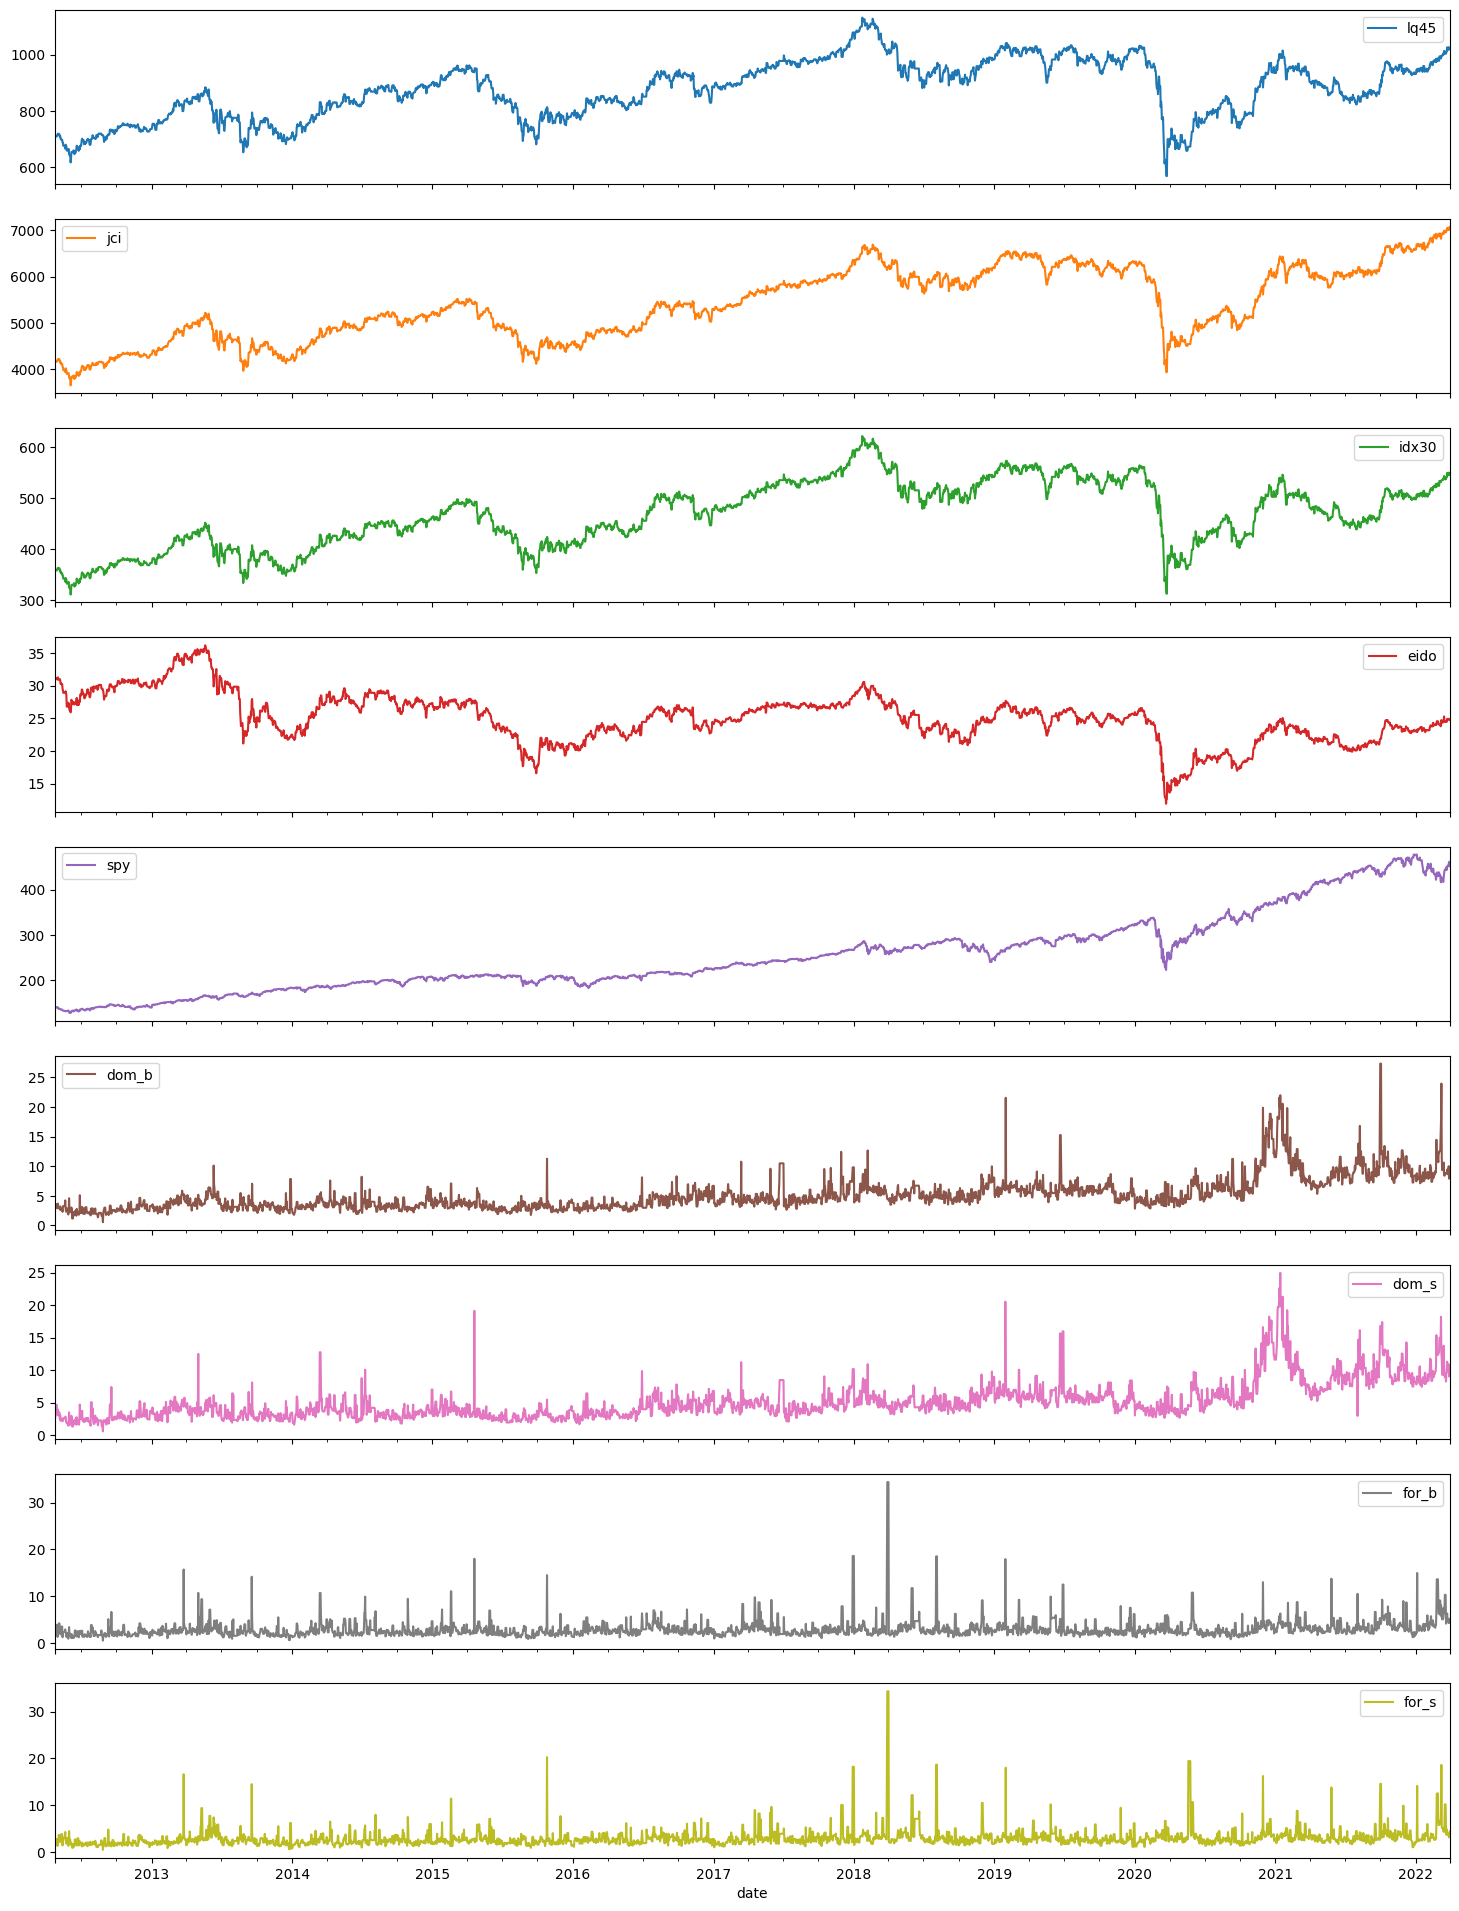

In [95]:
df_pre = df_raw.loc[:,df_raw.columns[:-3]].resample('D').mean().copy().fillna(method="ffill")
#df_pre = df_raw.loc[:,df_raw.columns[:-3]].resample('M').mean().copy()

df_pre.plot(subplots=True,figsize =(18,24))
pyplot.show()

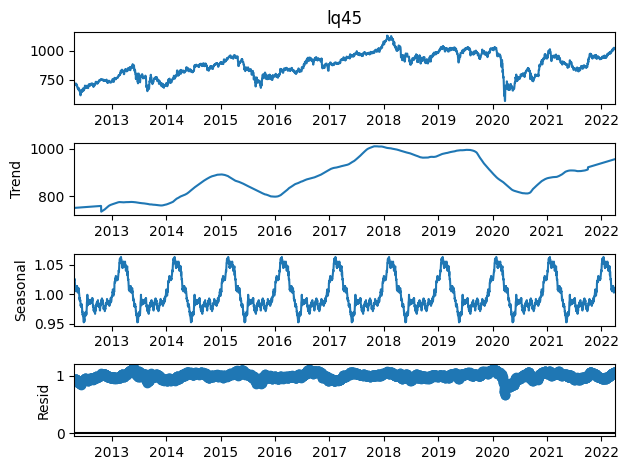

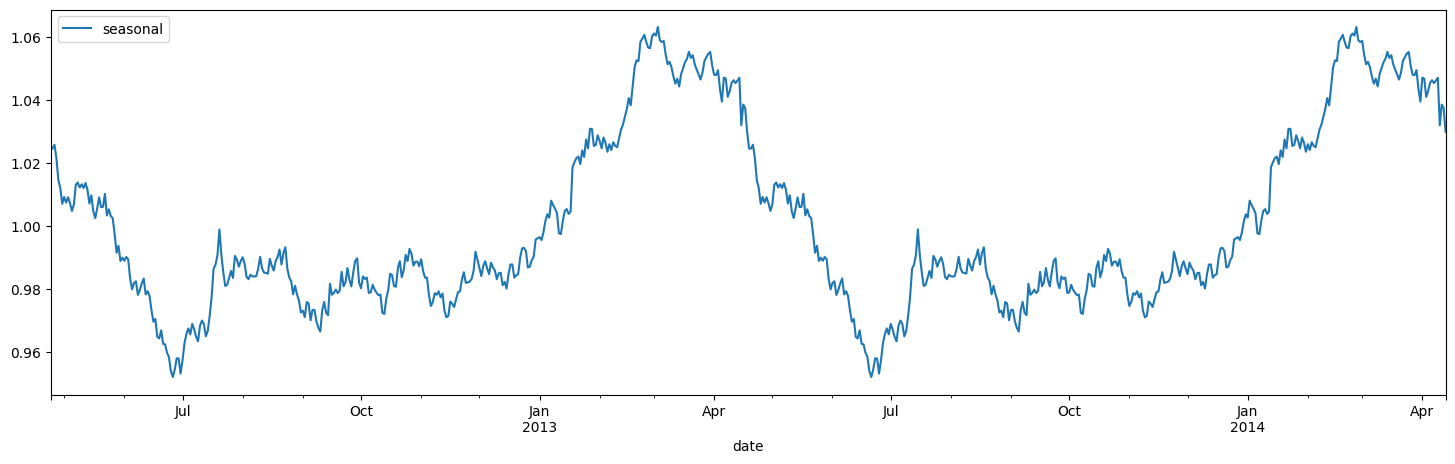

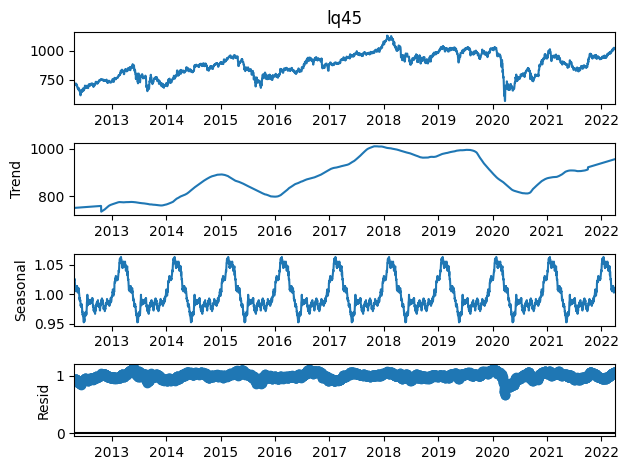

In [121]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df_pre['lq45'],#[7:372],   # 3 years
                                #model='additive', 
                                model='multiplicative', 
                                period=360,
                                extrapolate_trend='freq'
                                )

result_mul.seasonal[:720].to_frame().plot(subplots=True,figsize =(18,5))
result_mul.plot()

In [182]:
df_train=df_pre[(df_pre.index.get_level_values(0) <= '2020-12-31')]
df_test=df_pre[(df_pre.index.get_level_values(0) > '2020-12-31') & (df_pre.index.get_level_values(0) <= '2021-03-31')]

In [183]:
'''
model = pm.auto_arima(df_pre['lq45'], 
                         m=12, seasonal=True,
                         start_P=1, 
                         max_P=7,
                         start_Q=2,
                         max_Q=20,
                         #max_order=20, 
                         test='adf',
                         error_action='ignore',  
                         suppress_warnings=True,
                         stepwise=True, trace=True)
'''
model = pm.auto_arima(df_train['lq45'], 
                        X=df_train.loc[:, df_train.columns[1:]],
                        test='adf',
                        m=12, seasonal=True,
                        start_p=1, start_q=1,
                        max_p=3, max_q=3, 
                        start_P=0, 
                        d=None, D=1,
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=5202.600, Time=15.52 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=9097.736, Time=2.28 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=5536.033, Time=14.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=7526.113, Time=14.62 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=9136.744, Time=3.77 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=6091.877, Time=4.26 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=5090.012, Time=16.15 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=5538.177, Time=14.72 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=5118.706, Time=37.44 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=5160.858, Time=39.00 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=5156.676, Time=34.83 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=5301.892, Time=36.94 sec
 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=5166.997, Time=39.91 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=7525.572, Time=15.15 sec
 ARIMA(1

In [185]:
model.fit(df_train['lq45'])
forecast = model.predict(n_periods=len(df_test), 
                            #exogenous=df_pre.loc[:, df_pre.columns[1:]],
                            return_conf_int=True)
df_forecast = pd.concat([df_test['lq45'].reset_index(),
                        pd.DataFrame(forecast[0], columns=['prediction']).reset_index(drop=True)],
                        axis=1).set_index('date')
df_forecast.tail(20)

d:\ErcArinoto\myconda\_ml_project_lq45\venv_lq45\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


,lq45,prediction
date,,
2021-03-03,968.215,950.291872
2021-03-04,948.470,950.110867
2021-03-05,941.363,950.242954
2021-03-08,940.240,949.164642
2021-03-09,927.850,950.363785
2021-03-10,939.195,949.847665
2021-03-12,950.833,949.938713
2021-03-15,943.091,951.832588
2021-03-16,943.113,951.526477


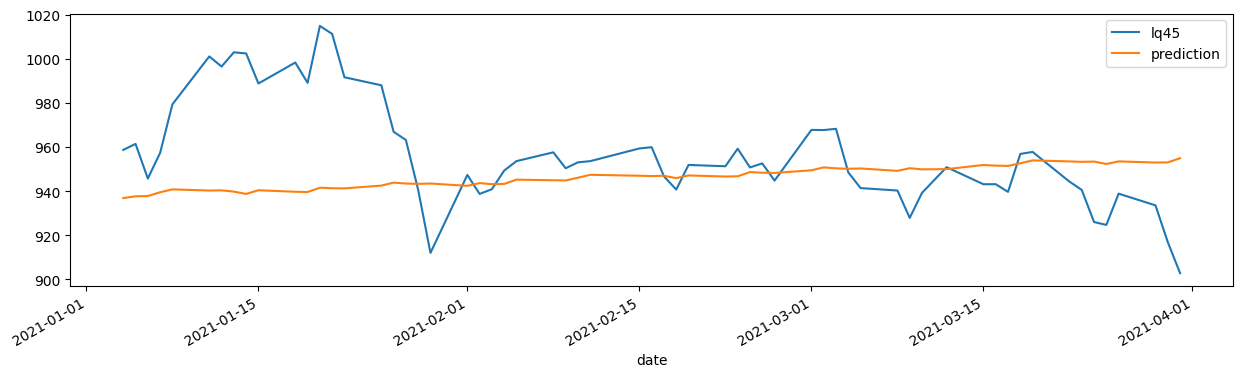

In [186]:
df_forecast.plot(figsize =(15,4))
pyplot.show()



In [ ]:
# Forecast
n_periods = 24
fitted, confint = model.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.value, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()